<table align="center" style="text-align:center">
    <tbody>
        <tr>
            <td colspan="15"><img src="https://raw.githubusercontent.com/TomWagg/tomwagg.github.io/main/img/milky_way_dcos.png"/></td>
            <td colspan="50">
                <h1 style="font-size:50px">Variations</h1>
                <h2 style="font-size:20px;"><i>Part of the notebook series for Wagg et al. 2021</i></h2>
                <p style="font-size:15px;">This notebook demonstrates how to reproduce the figures that examine the effect of varying underlying physics assumptions (Section 4, Figures 10-12, 15). In order to make these plots you'll need the data, which can be found <a href="https://zenodo.org/record/4699713">here</a> on Zenodo.</p>
            </td>
            <td colspan="15"><img src="https://raw.githubusercontent.com/TomWagg/tomwagg.github.io/main/img/milky_way_dcos.png"/></td>
        </tr>
    </tbody>
</table>

In [1]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import legwork

from matplotlib.ticker import FixedLocator
from matplotlib.lines import Line2D

import os

import sys
sys.path.append("../../simulation/src/")
from variations import variations
from galaxy import simulate_mw

import bootstrap as boots

# make plots look pleasant!
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [2]:
# define general things and get data
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2),
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../../simulation/data/simulation/"

total_DCOs_in_MW = np.load("../../simulation/data/total_DCO_in_MW.npy")

detections = np.load("../../simulation/data/detections_4yr.npy")
detections_10yr = np.load("../../simulation/data/detections_10yr.npy")

In [3]:
""" helper function for setting log spaced ticks """
def get_log_ticks(min_log, max_log):
    
    bottom = np.floor(min_log).astype(int)
    top = np.ceil(max_log).astype(int)
    
    ticks = []
    
    for i in range(bottom, top + 1):
        for j in range(2, 10):
            log_tick = np.log10(j * 10**(i))
            if log_tick > bottom and log_tick < top:
                ticks.append(log_tick)
                
    return ticks

# Component mass distribution over remnant mass prescriptions

Plotting mass for Fiducial
	Fraction of DCOs with 1 in mass gap: 0.55
Plotting mass for Fryer rapid SN remnant mass prescription
	Fraction of DCOs with 1 in mass gap: 0.00


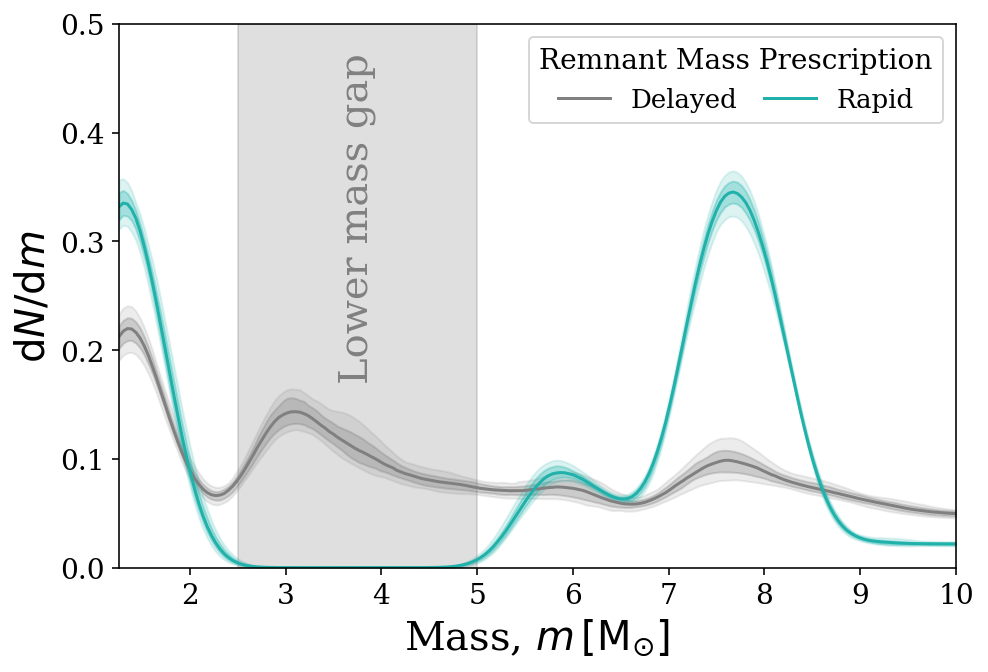

In [58]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
for model, style in [(0, "--"), (11, "-")]:
    bootstraps = 200
        
    mass = np.array([])
    weights = np.array([])
    seeds = np.array([])
    
    fraction_one_in_gap = np.zeros(len(dco_types))

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            something_in_mass_gap = np.logical_or(np.logical_and(data["m_1"] >= 2.5, data["m_1"] <= 5.0),
                                                  np.logical_and(data["m_2"] >= 2.5, data["m_2"] <= 5.0))
            
            fraction_one_in_gap[i] = np.sum(data["weight"][something_in_mass_gap]) / np.sum(data["weight"])
            
            mass = np.concatenate((mass, data["m_1"], data["m_2"]))
            weights = np.concatenate((weights, new_weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"], -1 * data["seed"]))
    
    overall_detected_fraction_in_gap = np.sum(fraction_one_in_gap * detections[:, 0].mean(axis=1)
                                              / detections[:, 0].mean(axis=1).sum())
    
    bw_adjust = 0.4

    # plot the distance distribution
    print("Plotting mass for", variations[model]["long"])
    print("\tFraction of DCOs with 1 in mass gap: {:1.2f}".format(overall_detected_fraction_in_gap))
    ax = boots.bootstrapped_kde(mass, weights, seeds, bw_adjust=bw_adjust,
                                ax=ax, color=variations[model]["colour"], label="Delayed" if model == 0 else "Rapid",
                                bootstraps=bootstraps, lower_bound=0.0, x_min=1.26, x_max=10)
            
ax.axvspan(2.5, 5.0, color="grey", alpha=0.25)
ax.annotate("Lower mass gap", xy=(3.75, 0.17), color="grey", rotation=90, ha="center", va="bottom", fontsize=fs)

ax.set_xlabel(r"Mass, $m \, [\rm M_{\odot}]$")
ax.set_xlim(1.26, 10)

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m$")

leg = ax.legend(loc='upper right', fontsize=0.65 * fs, ncol=2, columnspacing=1, title="Remnant Mass Prescription")
leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0, 0.5)

plt.savefig("../figures/lower_mass_gap_rapid_variation_detection_weighted.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Component mass distribution over mass loss efficiencies

Plotting mass for Fiducial
Plotting mass for Wolf-Rayet wind factor $f_{\rm WR} = 0.1$
Plotting mass for Wolf-Rayet wind factor $f_{\rm WR} = 5.0$


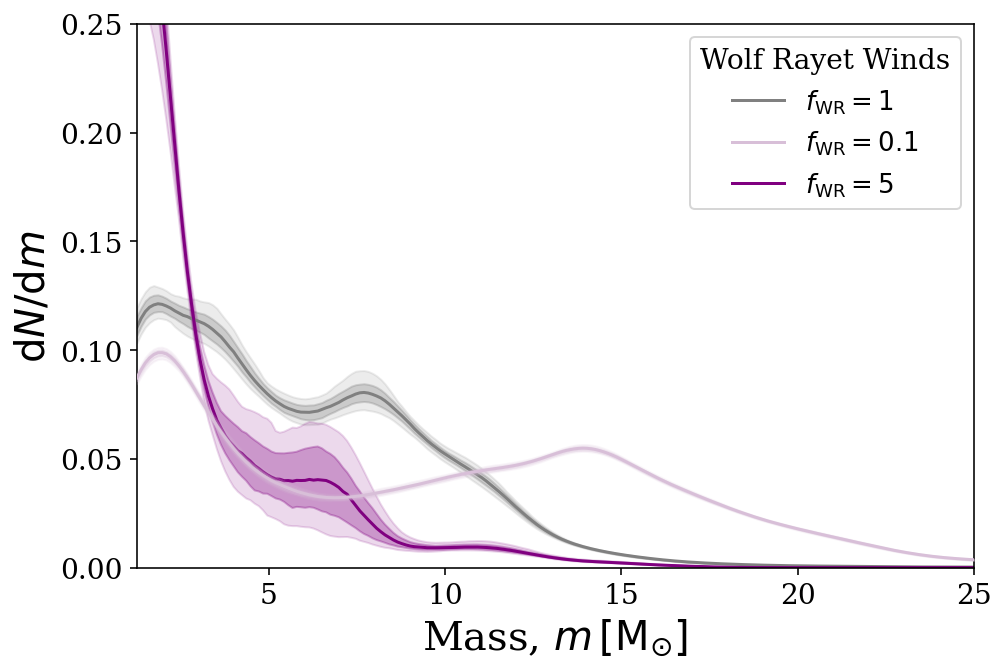

In [194]:
fig, ax = plt.subplots(figsize=(7.5, 5))
lw = 4
    
for model, label in [(0, r"$f_{\rm WR} = 1$"), (18, r"$f_{\rm WR} = 0.1$"), (19, r"$f_{\rm WR} = 5$")]:
    bootstraps = 200
        
    mass = np.array([])
    weights = np.array([])
    seeds = np.array([])

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
            new_weights = data["weight"] / data["weight"].sum() * detections[i][model].mean()
            
            mass = np.concatenate((mass, data["m_1"], data["m_2"]))
            weights = np.concatenate((weights, new_weights, new_weights))
            seeds = np.concatenate((seeds, data["seed"], -1 * data["seed"]))
    
    # plot the distance distribution
    print("Plotting mass for", variations[model]["long"])
    ax = boots.bootstrapped_kde(mass, weights, seeds,
                                ax=ax, color=variations[model]["colour"], label=label,
                                bootstraps=bootstraps, lower_bound=0.0, x_min=1.26, x_max=25, zorder=100 if model == 18 else None)

ax.set_xlabel(r"Mass, $m \, [\rm M_{\odot}]$")
ax.set_xlim(1.26, 25)

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m$")

leg = ax.legend(loc='upper right', fontsize=0.65 * fs, title="Wolf Rayet Winds")
leg.get_title().set_fontsize(0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(0, 0.25)

plt.savefig("../figures/wr_wind_mass_variations.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Eccentricity distribution over natal kick strengths

Plotting eccentricity for BHBH
Plotting eccentricity for BHNS
Plotting eccentricity for NSNS
Plotting eccentricity for BHBH
Plotting eccentricity for BHNS
Plotting eccentricity for NSNS


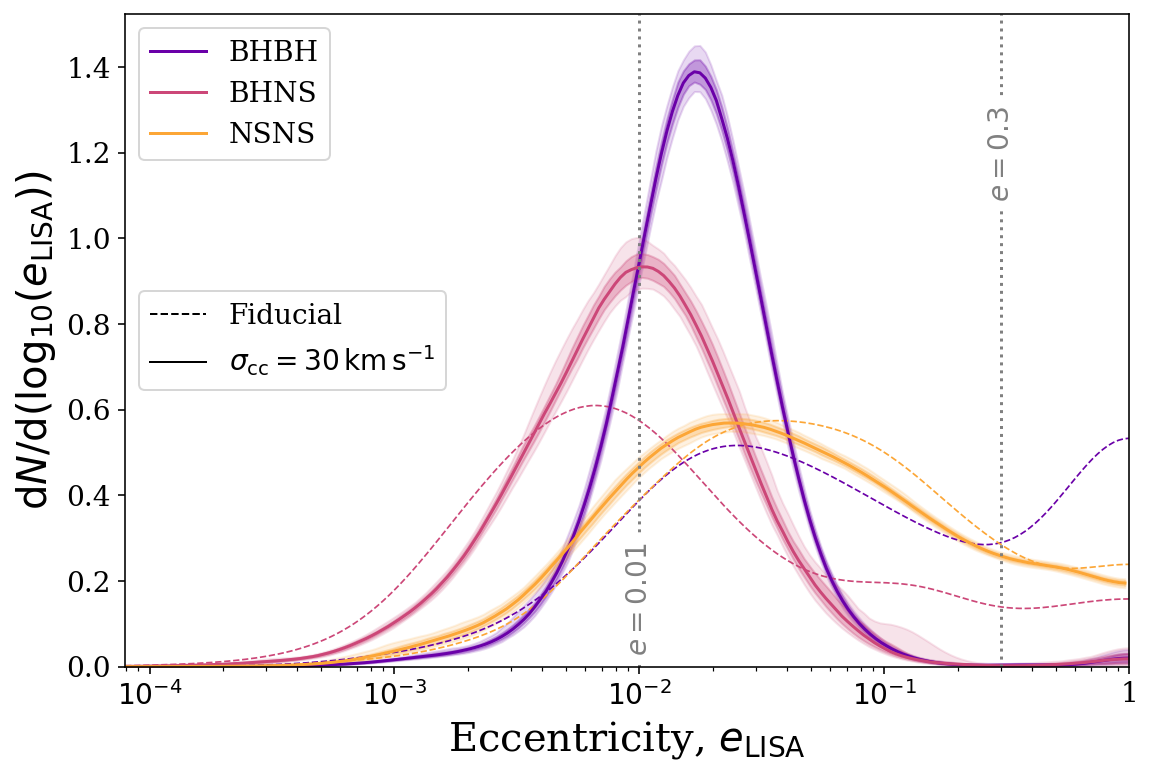

In [118]:
fig, ax = plt.subplots(figsize=(9, 6))
lw = 4
    
for model, style in [(0, "--"), (16, "-")]:
    if model == 0:
        bootstraps = None
    else:
        bootstraps = 200

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()

        # plot the distance distribution
        print("Plotting eccentricity for", dco_type)
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(np.log10(data["e_LISA"]), data["weight"], data["seed"], ax=ax, color=dco_colours[dco_type],
                                        label=dco_type, bootstraps=bootstraps, upper_bound=0.0, bw_adjust=1.5)
        else:
            sorted_order = np.argsort(data["seed"])
            sorted_seeds = data["seed"][sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(np.log10(data["e_LISA"][inds]), weights=data["weight"][inds] * counts, upper_bound=0.0, bw_adjust=1.5),
                    color=dco_colours[dco_type], linestyle=style, lw=0.85)

ax.set_xlabel(r"Eccentricity, $e_{\rm LISA}$")
ax.set_xlim(-4.1, 0)
ax.set_xticks([-4, -3, -2, -1, 0])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", "1"])
ax.xaxis.set_minor_locator(FixedLocator(get_log_ticks(*ax.get_xlim())))
ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (e_{\rm LISA}))$")


first_legend = plt.legend(loc='upper left', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1)]
ax.legend(handles=custom_lines, labels=["Fiducial", r"$\sigma_{\rm cc} = 30 \, \rm{km \, s^{-1}}$"],
          loc='center left', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

for e in [0.01, 0.3]:
    ax.axvline(np.log10(e), color="grey", linestyle="dotted")
    ax.annotate(r"$e = {{{}}}$".format(e), xy=(np.log10(e), 0.04 if e < 0.1 else 1.1), color="grey",
                        bbox=dict(boxstyle="round", ec="white", fc="white"), ha="center", rotation=90, fontsize=0.7*fs, zorder=2)

plt.savefig("../figures/ecc_low_kick_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Mass distribution for simple MW
For the last section, we make a plot of the mass distribution for the simple Milky Way model that we explore in the appendix of the paper.

../../simulation/data/simple_mw_simulation/simple_mw_
Plotting mass for BHBH
Plotting mass for BHNS
../../simulation/data/simulation/
Plotting mass for BHBH
Plotting mass for BHNS


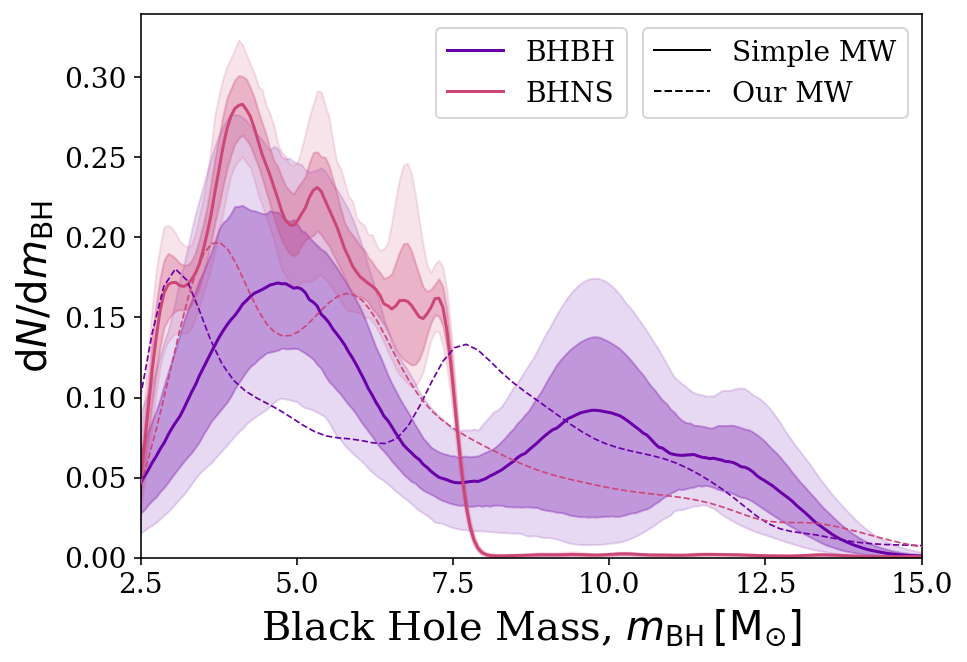

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
lw = 4
    
for folder, style in [("../../simulation/data/simple_mw_simulation/simple_mw_", "-"), (sim_folder, "--")]:
    print(folder)
    if folder == sim_folder:
        bootstraps = None
    else:
        bootstraps = 200

    for i, dco_type in enumerate(["BHBH", "BHNS"]):
        # open corresponding COMPAS file
        with h5.File(folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
        # work out which masses are the BH and NS masses
        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))

        # plot the distance distribution
        print("Plotting mass for", dco_type)
        bw_adjust = 0.5
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=bw_adjust,
                                                    ax=ax, color=dco_colours[dco_type], label=dco_type,
                                                    bootstraps=bootstraps, lower_bound=0.0, x_min=2.5, x_max=15)
        else:
            sorted_order = np.argsort(mass_seeds)
            sorted_seeds = mass_seeds[sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(mBH[inds], weights=mass_weights[inds] * counts, lower_bound=0.0, bw_adjust=bw_adjust, x_min=2.5),
                                color=dco_colours[dco_type], linestyle=style, lw=0.85, zorder=10)

ax.set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
ax.set_xlim(2.5, 15)
ax.set_xticks([2.5, 5, 7.5, 10, 12.5, 15])

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m_{\rm BH}$")


first_legend = plt.legend(loc='upper center', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="black", lw=1, linestyle="--")]
ax.legend(handles=custom_lines, labels=["Simple MW", "Our MW"],
          loc='upper right', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

plt.savefig("../figures/mBH_simple_mw_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

BHBH 0
BHBH 1
BHBH 2
BHBH 3


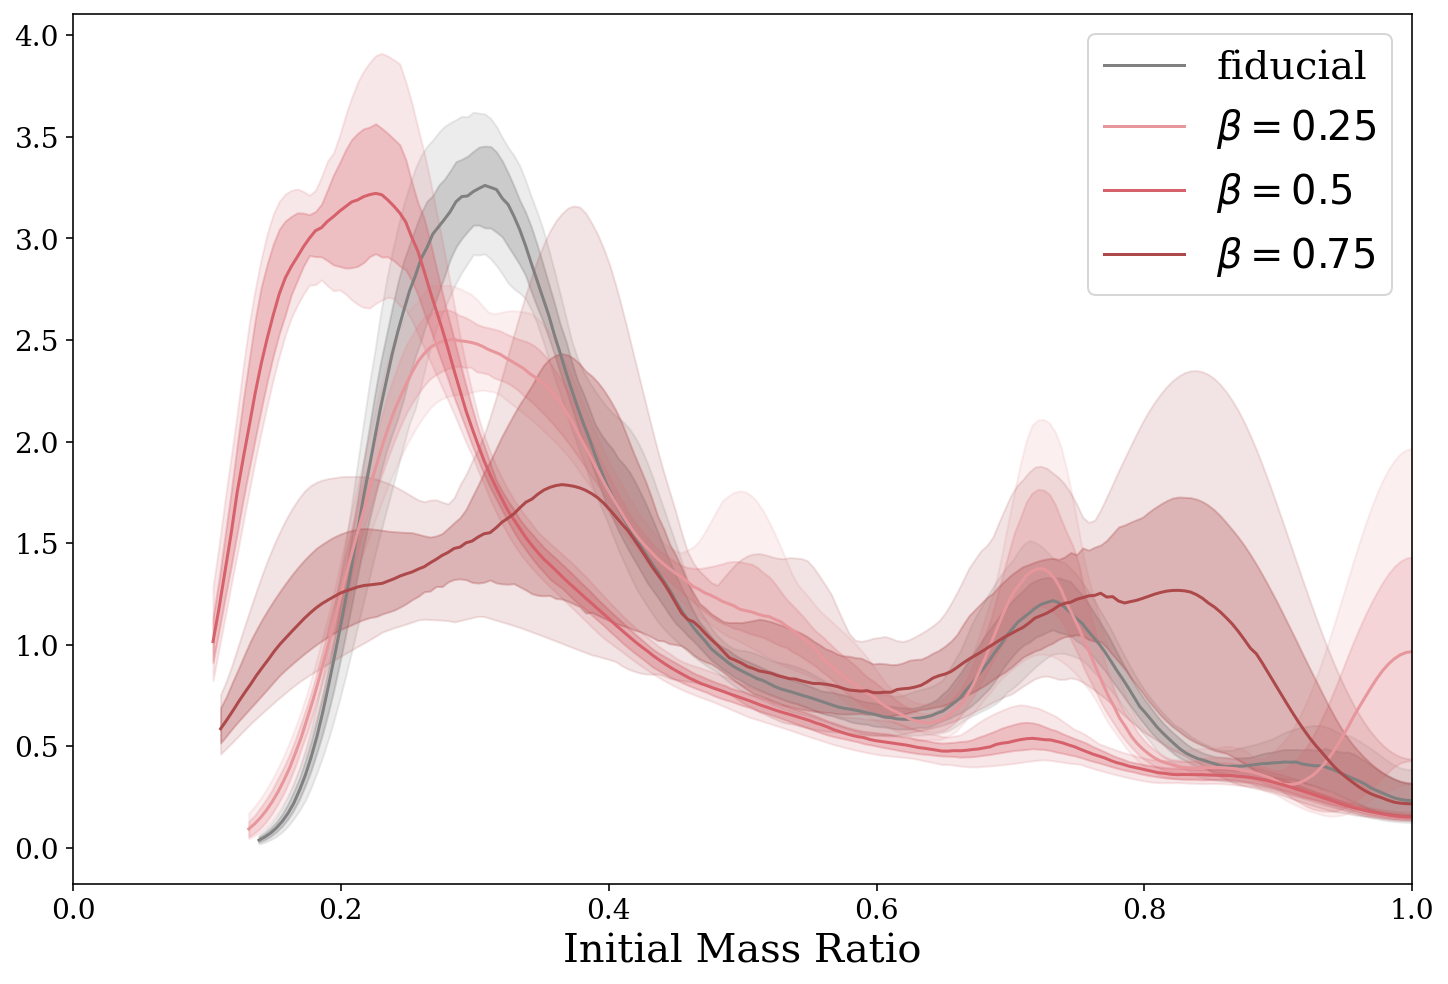

BHNS 0
BHNS 1
BHNS 2
BHNS 3


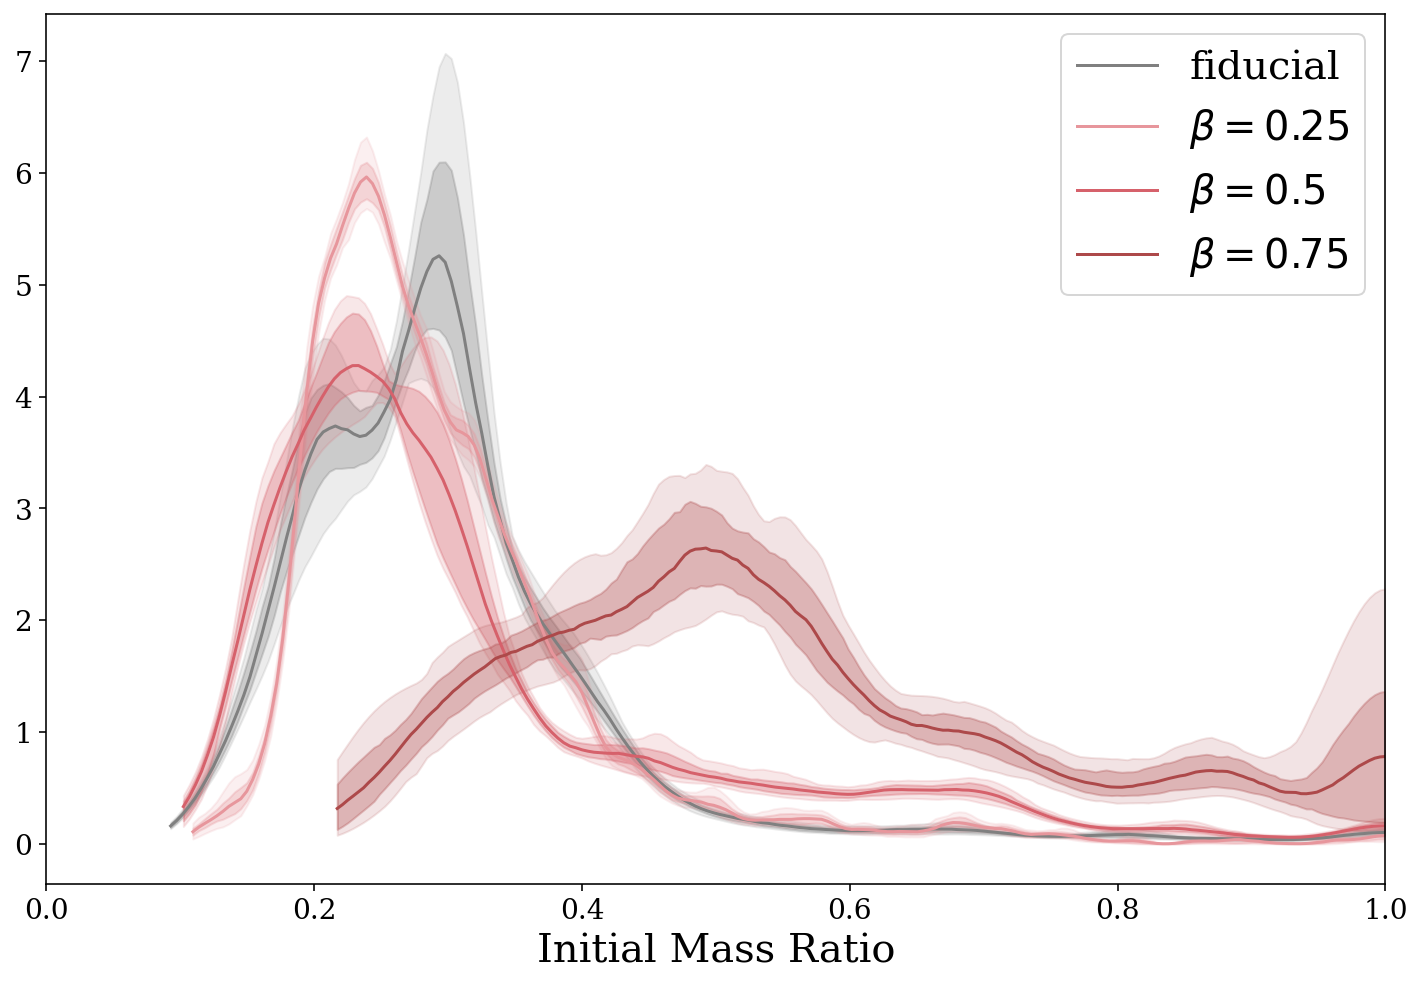

NSNS 0
NSNS 1
NSNS 2
NSNS 3


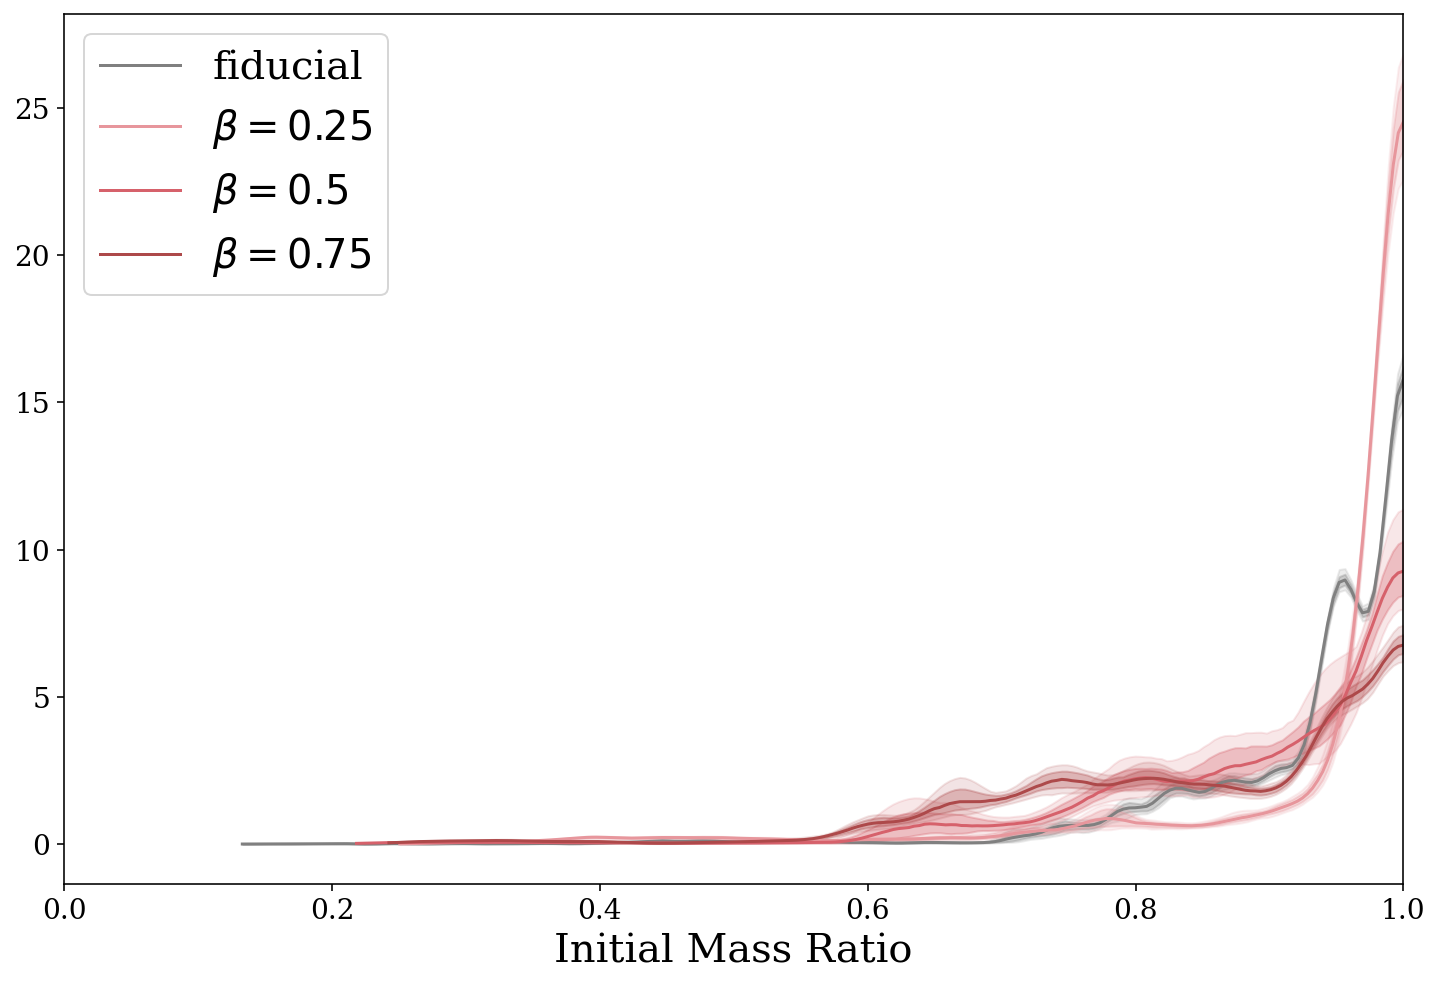

In [9]:
for dco_type in dco_types:
    fig, ax = plt.subplots()
    
    for model in [0, 1, 2, 3]:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
        
        q_ZAMS = data["m_2_ZAMS"] / data["m_1_ZAMS"]
        ax = boots.bootstrapped_kde(q_ZAMS, data["weight"], data["seed"], ax=ax, color=variations[model]["colour"],
                                        label=variations[model]["med"], bootstraps=100, lower_bound=0.0, upper_bound=1.0, bw_adjust=0.5)
        print(dco_type, model)
        
    ax.set_xlim(0, 1)
    ax.set_xlabel("Initial Mass Ratio")
    ax.legend()
        
    plt.show()